In [4]:
import torch
from gridworld.tile_types import TileType
from gridworld.world import World
from gridworld.agent import Agent
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
#from spiking_feast import SpikingFEASTNetwork
from models.rstdp import SNN

lr = 1e-2
num_epochs = 100
num_steps_per_epoch = 500
#num_ticks_per_step = 50
reward = 0
action = 0
p_random_action_initial = 1.0
p_random_action_decay = 0.99 # 1 means no decay

hidden_size = 100
hidden_size2 = 100

num_steps_for_inference = 100
num_steps_for_learning = 100

world: World = World()
agent: Agent = Agent()
duration_history = []

#weights_1_history = torch.zeros((num_epochs, agent.input_size, agent.hidden_size))
#net = SpikingFEASTNetwork(agent.input_size, agent.hidden_size, hidden_size2, agent.output_size, lr=5)
net = SNN(agent.input_size, 32, agent.output_size)

def simulate_epoch() -> int:
    step: int = 0
    reward: float = 0.0
    p_random_action: float = p_random_action_initial
    
    #weights_1_history[step] = agent.model.input_layer.weights # type: ignore
    
    for step in range(num_steps_per_epoch):
         
        # Decay the learning parameters
        p_random_action *= p_random_action_decay
        
        # Generate the visual input
        agent.update_visual_field(world)
        
        # Compute the action from the feed-forward neural network
        for _ in range(num_steps_for_inference):
            net.forward(agent.visual_field)
        action = int(torch.argmax(net.output_layer.post_synaptic_potential).item())
        
        # Take the action and get the reward
        if torch.rand(1) < p_random_action:
            action = int(torch.randint(low=0, high=len(agent.actions), size=(1,)).item())
        reward = agent.step(action, world)

        # Force the neuron producing the correct response to burst spikes, allowing
        # STDP to backpropagate the reward signal
        net.output_layer.post_synaptic_potential[action] = reward
        for _ in range(num_steps_for_learning):
            net.forward(agent.visual_field)
        
        # Exit early if the agent is done
        if world.is_complete():
            break
    return step

# Training loop
for _ in tqdm(range(num_epochs), desc='Epoch', leave=True):
    # Initialize the session 
    world.reset()

    sim_duration = simulate_epoch()
        
    # Update the performance history
    duration_history.append(sim_duration)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: 'random' is not in list

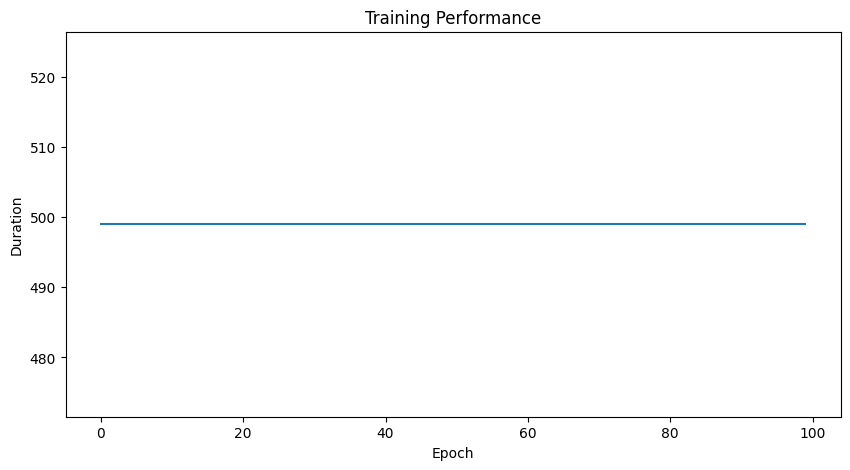

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(duration_history)
plt.ylabel('Duration')
plt.xlabel('Epoch')
plt.title('Training Performance');